In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [3]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [5]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [7]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 1),
            # nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

Initialize the Neural Networks and Define the Optimizers

In [8]:


generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)
######################


In [9]:
# optimizers
optim_g = optim.RMSprop(generator.parameters(), lr=0.0001)
optim_d = optim.RMSprop(discriminator.parameters(), lr=0.0001)
# optim_g = optim.RMSprop(generator.parameters(), lr=0.0001, weight_decay=0.1)
# optim_d = optim.RMSprop(discriminator.parameters(), lr=0.0001, weight_decay=0.1)

In [10]:
# loss function
# criterion = nn.BCELoss()


In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [11]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    # b_size = data_real.size(0)
    # real_label = label_real(b_size)
    # fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    # loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss = -(torch.mean(output_real) - torch.mean(output_fake))
    # loss_fake = criterion(output_fake, fake_label)
    loss.backward()
    optimizer.step()
    return loss

In [14]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    # b_size = data_fake.size(0)
    # real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = -torch.mean(output)
    loss.backward()
    optimizer.step()
    return loss

In [15]:
# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

path = "/content/drive/MyDrive/Deep_Learning/HW3/outputs_wasserstein/"
# path = ""
epochs = 200
c = 0.01
# k = 10

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    # for bi, data in tqdm(enumerate(data_loader), total=int(len(fmnist)/data_loader.batch_size)):
    for bi, data in enumerate(data_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            # print(create_noise(b_size, nz).shape)
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    # noise = create_noise(b_size, nz)
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, path + f"gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    for p in discriminator.parameters():
        p.data.clamp_(-c, c)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: -326.09674072, Discriminator loss: 70.83267975
Epoch 1 of 200
Generator loss: 106.83279419, Discriminator loss: -89.28650665
Epoch 2 of 200
Generator loss: -15.39817333, Discriminator loss: -1.63134706
Epoch 3 of 200
Generator loss: -6.33869553, Discriminator loss: -0.04898592
Epoch 4 of 200
Generator loss: -2.59076405, Discriminator loss: -6.36768913
Epoch 5 of 200
Generator loss: -1.97435176, Discriminator loss: 4.57577085
Epoch 6 of 200
Generator loss: -0.08050862, Discriminator loss: 0.14847884
Epoch 7 of 200
Generator loss: -0.00042334, Discriminator loss: 0.00491790
Epoch 8 of 200
Generator loss: -0.00000484, Discriminator loss: -0.00045711
Epoch 9 of 200
Generator loss: -0.00001360, Discriminator loss: -0.00149240
Epoch 10 of 200
Generator loss: -0.00007807, Discriminator loss: -0.00673344
Epoch 11 of 200
Generator loss: -4.75844860, Discriminator loss: -0.99744165
Epoch 12 of 200
Generator loss: -5.49211121, Discriminator loss: -0.94109958
Epoch 1

In [51]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'generator.pth')
path

DONE TRAINING


'/content/drive/MyDrive/Deep_Learning/HW3/outputs_wasserstein/'

In [52]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'generator_images.gif', imgs)

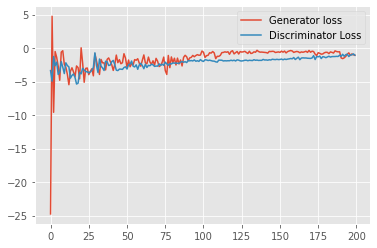

In [55]:
plt.figure()
plt.plot(losses_g[91:], label='Generator loss')
plt.plot(losses_d[91:], label='Discriminator Loss')
plt.legend()
plt.savefig(path + 'loss.png')

In [54]:
len(losses_d)

291